In [1]:
# 1. 必要なライブラリ
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import tqdm

# 2. ImageNetデータセット（サンプル/サブセット推奨）
data_dir = './imagenet-256'  # サンプルディレクトリ
transform = transforms.Compose([
    transforms.Resize(64),  # 拡散モデルは小さめ画像が推奨
    transforms.CenterCrop(64),
    transforms.ToTensor(),
])
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
loader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)

# 3. スコアネット（DiffPure類似）
class GaussianFourierProjection(nn.Module):
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class Dense(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        return self.dense(x)[..., None, None]

class ScoreNet(nn.Module):
    def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
        super().__init__()
        self.embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim)
        )
        self.conv1 = nn.Conv2d(3, channels[0], 3, stride=1, padding=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, channels[0])
        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, padding=1, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, channels[1])
        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, padding=1, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, channels[2])
        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, padding=1, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, channels[3])
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 4, stride=2, padding=1, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, channels[2])
        self.tconv3 = nn.ConvTranspose2d(channels[2]+channels[2], channels[1], 4, stride=2, padding=1, bias=False)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, channels[1])
        self.tconv2 = nn.ConvTranspose2d(channels[1]+channels[1], channels[0], 4, stride=2, padding=1, bias=False)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, channels[0])
        self.tconv1 = nn.ConvTranspose2d(channels[0]+channels[0], 3, 3, stride=1, padding=1)
        self.act = lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std
    def forward(self, x, t):
        embed = self.act(self.embed(t))
        h1 = self.act(self.gnorm1(self.conv1(x) + self.dense1(embed)))
        h2 = self.act(self.gnorm2(self.conv2(h1) + self.dense2(embed)))
        h3 = self.act(self.gnorm3(self.conv3(h2) + self.dense3(embed)))
        h4 = self.act(self.gnorm4(self.conv4(h3) + self.dense4(embed)))
        h = self.act(self.tgnorm4(self.tconv4(h4) + self.dense5(embed)))
        h = self.act(self.tgnorm3(self.tconv3(torch.cat([h, h3], dim=1)) + self.dense6(embed)))
        h = self.act(self.tgnorm2(self.tconv2(torch.cat([h, h2], dim=1)) + self.dense7(embed)))
        h = self.tconv1(torch.cat([h, h1], dim=1))
        h = h / self.marginal_prob_std(t)[:, None, None, None]
        return h

# 4. 拡散過程の関数
import functools
def marginal_prob_std(t, sigma):
    t = torch.tensor(t, device=device)
    return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))
def diffusion_coeff(t, sigma):
    return torch.tensor(sigma**t, device=device)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
sigma = 25.0
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

# 5. 学習ループ
score_model = ScoreNet(marginal_prob_std=marginal_prob_std_fn).to(device)
optimizer = optim.Adam(score_model.parameters(), lr=2e-4)
n_epochs = 100
# ...existing code...
best_loss = float('inf')
for epoch in range(n_epochs):
    score_model.train()
    avg_loss = 0.
    num_items = 0
    for x, _ in tqdm.tqdm(loader, desc=f"Epoch {epoch+1}"):
        x = x.to(device)
        random_t = torch.rand(x.shape[0], device=x.device) * 0.999 + 0.001
        z = torch.randn_like(x)
        std = marginal_prob_std_fn(random_t)
        perturbed_x = x + z * std[:, None, None, None]
        score = score_model(perturbed_x, random_t)
        loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
    epoch_loss = avg_loss / num_items
    print(f"Epoch {epoch+1} | Loss: {epoch_loss:.4f}")

    # 最良モデル保存
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(score_model.state_dict(), "score_model_best.pth")
        print(f"Best model saved (Loss: {best_loss:.4f})")

# 最終エポックのモデルも保存したい場合
torch.save(score_model.state_dict(), "score_model_last.pth")
print("Last model saved.")
# ...existing code...

# 6. 画像生成（サンプリング）
def pc_sampler(score_model, marginal_prob_std, diffusion_coeff, batch_size=8, num_steps=500, snr=0.16, device='cuda', eps=1e-3):
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, 3, 64, 64, device=device) * marginal_prob_std(t)[:, None, None, None]
    time_steps = np.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    with torch.no_grad():
        for time_step in tqdm.tqdm(time_steps, desc="PC Sampling"):
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            grad = score_model(x, batch_time_step)
            grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
            grad_norm = torch.clamp(grad_norm, min=1e-5)
            noise_norm = np.sqrt(np.prod(x.shape[1:]))
            langevin_step_size = 2 * (snr * noise_norm / grad_norm) ** 2
            x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)
            g = diffusion_coeff(batch_time_step).view(-1, 1, 1, 1)
            score = score_model(x, batch_time_step)
            x_mean = x + (g ** 2) * score * step_size
            x = x_mean + torch.sqrt(g ** 2 * step_size) * torch.randn_like(x)
    return x_mean

score_model.eval()
samples = pc_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, batch_size=8, num_steps=500, device=device)
samples = samples.clamp(0., 1.).cpu()

# 7. 生成画像の表示
fig, axes = plt.subplots(2, 4, figsize=(8, 4))
for i in range(8):
    ax = axes[i // 4, i % 4]
    img = samples[i].permute(1, 2, 0).numpy()
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

Epoch 1:   0%|          | 0/4218 [00:00<?, ?it/s]/tmp/ipykernel_131676/1554620599.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
Epoch 1: 100%|██████████| 4218/4218 [05:34<00:00, 12.60it/s]


Epoch 1 | Loss: 913.5976
Best model saved (Loss: 913.5976)


Epoch 2: 100%|██████████| 4218/4218 [05:30<00:00, 12.77it/s]


Epoch 2 | Loss: 230.8740
Best model saved (Loss: 230.8740)


Epoch 3: 100%|██████████| 4218/4218 [05:42<00:00, 12.33it/s]


Epoch 3 | Loss: 198.9600
Best model saved (Loss: 198.9600)


Epoch 4: 100%|██████████| 4218/4218 [05:35<00:00, 12.58it/s]


Epoch 4 | Loss: 187.1858
Best model saved (Loss: 187.1858)


Epoch 5: 100%|██████████| 4218/4218 [05:34<00:00, 12.60it/s]


Epoch 5 | Loss: 180.7017
Best model saved (Loss: 180.7017)


Epoch 6: 100%|██████████| 4218/4218 [05:37<00:00, 12.49it/s]


Epoch 6 | Loss: 177.4031
Best model saved (Loss: 177.4031)


Epoch 7: 100%|██████████| 4218/4218 [05:41<00:00, 12.35it/s]


Epoch 7 | Loss: 174.4573
Best model saved (Loss: 174.4573)


Epoch 8: 100%|██████████| 4218/4218 [05:34<00:00, 12.62it/s]


Epoch 8 | Loss: 171.5236
Best model saved (Loss: 171.5236)


Epoch 9: 100%|██████████| 4218/4218 [05:31<00:00, 12.72it/s]


Epoch 9 | Loss: 170.3895
Best model saved (Loss: 170.3895)


Epoch 10: 100%|██████████| 4218/4218 [05:32<00:00, 12.69it/s]


Epoch 10 | Loss: 168.7664
Best model saved (Loss: 168.7664)


Epoch 11: 100%|██████████| 4218/4218 [05:34<00:00, 12.61it/s]


Epoch 11 | Loss: 168.0272
Best model saved (Loss: 168.0272)


Epoch 12: 100%|██████████| 4218/4218 [05:34<00:00, 12.60it/s]


Epoch 12 | Loss: 167.0456
Best model saved (Loss: 167.0456)


Epoch 13: 100%|██████████| 4218/4218 [05:36<00:00, 12.53it/s]


Epoch 13 | Loss: 165.6975
Best model saved (Loss: 165.6975)


Epoch 14: 100%|██████████| 4218/4218 [05:36<00:00, 12.53it/s]


Epoch 14 | Loss: 165.1097
Best model saved (Loss: 165.1097)


Epoch 15: 100%|██████████| 4218/4218 [05:41<00:00, 12.35it/s]


Epoch 15 | Loss: 164.0463
Best model saved (Loss: 164.0463)


Epoch 16: 100%|██████████| 4218/4218 [05:34<00:00, 12.60it/s]


Epoch 16 | Loss: 163.5626
Best model saved (Loss: 163.5626)


Epoch 17: 100%|██████████| 4218/4218 [05:40<00:00, 12.37it/s]


Epoch 17 | Loss: 163.1221
Best model saved (Loss: 163.1221)


Epoch 18: 100%|██████████| 4218/4218 [05:35<00:00, 12.59it/s]


Epoch 18 | Loss: 163.5177


Epoch 19: 100%|██████████| 4218/4218 [05:35<00:00, 12.59it/s]


Epoch 19 | Loss: 162.5990
Best model saved (Loss: 162.5990)


Epoch 20: 100%|██████████| 4218/4218 [05:40<00:00, 12.38it/s]


Epoch 20 | Loss: 162.2460
Best model saved (Loss: 162.2460)


Epoch 21: 100%|██████████| 4218/4218 [05:43<00:00, 12.28it/s]


Epoch 21 | Loss: 161.9863
Best model saved (Loss: 161.9863)


Epoch 22: 100%|██████████| 4218/4218 [05:37<00:00, 12.50it/s]


Epoch 22 | Loss: 161.8076
Best model saved (Loss: 161.8076)


Epoch 23: 100%|██████████| 4218/4218 [05:39<00:00, 12.43it/s]


Epoch 23 | Loss: 160.9659
Best model saved (Loss: 160.9659)


Epoch 24: 100%|██████████| 4218/4218 [05:35<00:00, 12.56it/s]


Epoch 24 | Loss: 161.7504


Epoch 25: 100%|██████████| 4218/4218 [05:39<00:00, 12.43it/s]


Epoch 25 | Loss: 160.6740
Best model saved (Loss: 160.6740)


Epoch 26: 100%|██████████| 4218/4218 [05:40<00:00, 12.37it/s]


Epoch 26 | Loss: 160.7189


Epoch 27: 100%|██████████| 4218/4218 [05:40<00:00, 12.39it/s]


Epoch 27 | Loss: 159.8753
Best model saved (Loss: 159.8753)


Epoch 28: 100%|██████████| 4218/4218 [05:35<00:00, 12.57it/s]


Epoch 28 | Loss: 160.0589


Epoch 29: 100%|██████████| 4218/4218 [05:38<00:00, 12.48it/s]


Epoch 29 | Loss: 159.3379
Best model saved (Loss: 159.3379)


Epoch 30: 100%|██████████| 4218/4218 [05:37<00:00, 12.49it/s]


Epoch 30 | Loss: 159.5079


Epoch 31:  57%|█████▋    | 2405/4218 [03:13<02:25, 12.43it/s]


KeyboardInterrupt: 

In [3]:
# 6. 画像生成（サンプリング）
def pc_sampler(score_model, marginal_prob_std, diffusion_coeff, batch_size=8, num_steps=500, snr=0.16, device='cuda', eps=1e-3):
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, 3, 64, 64, device=device) * marginal_prob_std(t)[:, None, None, None]
    time_steps = np.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    with torch.no_grad():
        for time_step in tqdm.tqdm(time_steps, desc="PC Sampling"):
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            grad = score_model(x, batch_time_step)
            grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
            grad_norm = torch.clamp(grad_norm, min=1e-5)
            noise_norm = np.sqrt(np.prod(x.shape[1:]))
            langevin_step_size = 2 * (snr * noise_norm / grad_norm) ** 2
            x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)
            g = diffusion_coeff(batch_time_step).view(-1, 1, 1, 1)
            score = score_model(x, batch_time_step)
            x_mean = x + (g ** 2) * score * step_size
            x = x_mean + torch.sqrt(g ** 2 * step_size) * torch.randn_like(x)
    return x_mean

/tmp/ipykernel_131676/1554620599.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
PC Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipykernel_131676/1554620599.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)
PC Sampling: 100%|██████████| 500/500 [00:02<00:00, 205.70it/s]


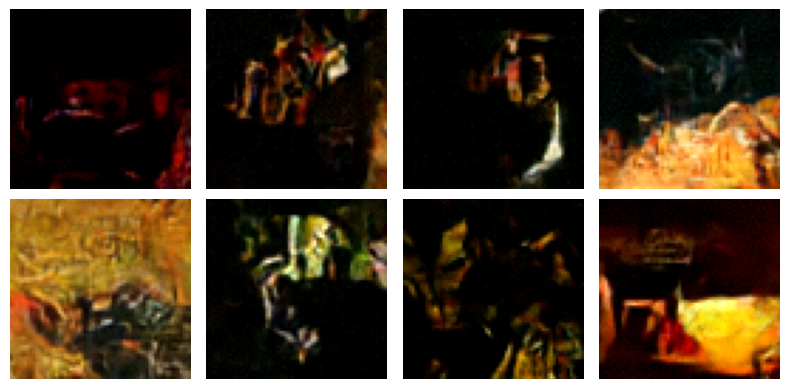

In [4]:
import torch

# 1. モデルの定義を再利用してインスタンス化
score_model = ScoreNet(marginal_prob_std=marginal_prob_std_fn).to(device)

# 2. 学習済みパラメータをロード
score_model.load_state_dict(torch.load("score_model_best.pth", map_location=device))

# 3. 評価モードに切り替え
score_model.eval()

# 4. サンプル生成
samples = pc_sampler(
    score_model, 
    marginal_prob_std_fn, 
    diffusion_coeff_fn, 
    batch_size=8,      # 生成枚数
    num_steps=500,     # ステップ数（多いほど高品質）
    device=device
)

# 5. [0,1] 範囲にクリップ
samples = samples.clamp(0., 1.).cpu()

# 6. 可視化
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 4, figsize=(8, 4))
for i in range(8):
    ax = axes[i // 4, i % 4]
    img = samples[i].permute(1, 2, 0).numpy()
    ax.imshow(img)
    ax.axis("off")
plt.tight_layout()
plt.show()
